In [1]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import torch.nn as nn
from tqdm import tqdm 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt


/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'


train_df = pd.read_csv('/home/mmc/disk2/duck/cap/cnn/drink_2/RMBG_224/train/drink.csv')
val_df = pd.read_csv('/home/mmc/disk2/duck/cap/cnn/drink_2/RMBG_224/val/drink.csv')
num_classes = 10


print(f'train shape: {train_df.shape}\nval shape: {val_df.shape}')

train shape: (61, 4)
val shape: (9, 4)


In [3]:
class PixelDropout(object):
    def __init__(self, dropout_prob=0.1):
        self.dropout_prob = dropout_prob

    def __call__(self, img):
        mask = torch.rand_like(img) > self.dropout_prob
        img = img * mask
        return img


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.img_labels = annotations_file
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx]['class']
        if self.transform:
            image = self.transform(image)
        return image, label


# 데이터 전처리
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.RandomApply([transforms.RandomResizedCrop((224, 224))], p=0.3),
    # transforms.RandomHorizontalFlip(),  # 좌우 반전
    # transforms.RandomRotation(10),  # 30도 이내의 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 밝기, 대비, 채도, 색조 변화
    transforms.ToTensor(),
    # PixelDropout(dropout_prob=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 사용자 정의 데이터셋 인스턴스 생성
train_dataset = CustomImageDataset(train_df,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataset = CustomImageDataset(val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)


In [4]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomImageClassifier, self).__init__()
        self.base_model = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = self.base_model(x)
        return x


# 모델을 생성합니다.
model = CustomImageClassifier(num_classes)

# 저장된 가중치를 로드합니다.
# model.load_state_dict(torch.load('./snack_pt_0518_resnet18/last_0.033.pt'))

# 모델을 적절한 장치로 이동시킵니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CustomImageClassifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)


/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Validation Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 12.34it/s]


Epoch 1, Train Loss: 2.3602938652038574, Val Loss: 2.1012092232704163
Model saved: Epoch 1 with Val Loss: 2.1012


Validation Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 31.00it/s]


Epoch 2, Train Loss: 2.1773140132427216, Val Loss: 2.2809418439865112


Validation Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 34.03it/s]


Epoch 3, Train Loss: 1.9764819592237473, Val Loss: 2.218662738800049


Validation Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 33.85it/s]


Epoch 4, Train Loss: 1.6348601579666138, Val Loss: 1.8023641705513
Model saved: Epoch 4 with Val Loss: 1.8024


Validation Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 32.82it/s]


Epoch 5, Train Loss: 1.2187894433736801, Val Loss: 1.2877569198608398
Model saved: Epoch 5 with Val Loss: 1.2878


Validation Epoch 6: 100%|██████████| 2/2 [00:00<00:00, 40.41it/s]


Epoch 6, Train Loss: 0.8209818676114082, Val Loss: 0.3903435319662094
Model saved: Epoch 6 with Val Loss: 0.3903


Validation Epoch 7: 100%|██████████| 2/2 [00:00<00:00, 32.93it/s]


Epoch 7, Train Loss: 0.36738920398056507, Val Loss: 0.1527290940284729
Model saved: Epoch 7 with Val Loss: 0.1527


Validation Epoch 8: 100%|██████████| 2/2 [00:00<00:00, 32.83it/s]


Epoch 8, Train Loss: 0.13958503305912018, Val Loss: 0.047975570894777775
Model saved: Epoch 8 with Val Loss: 0.0480


Validation Epoch 9: 100%|██████████| 2/2 [00:00<00:00, 32.78it/s]


Epoch 9, Train Loss: 0.06282058451324701, Val Loss: 0.11147606186568737


Validation Epoch 10: 100%|██████████| 2/2 [00:00<00:00, 33.24it/s]


Epoch 10, Train Loss: 0.06106060463935137, Val Loss: 0.04345971532166004
Model saved: Epoch 10 with Val Loss: 0.0435


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


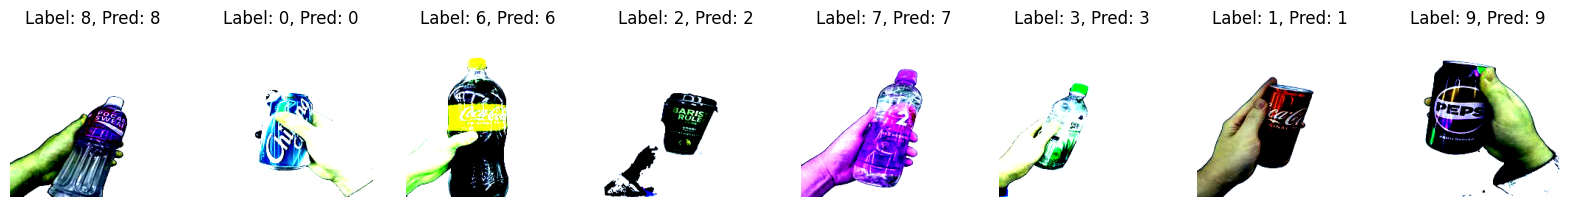

Validation Epoch 11: 100%|██████████| 2/2 [00:00<00:00, 33.98it/s]


Epoch 11, Train Loss: 0.054228408611379564, Val Loss: 0.006017780920956284
Model saved: Epoch 11 with Val Loss: 0.0060


Validation Epoch 12: 100%|██████████| 2/2 [00:00<00:00, 33.89it/s]


Epoch 12, Train Loss: 0.05058276455383748, Val Loss: 0.12412915006279945


Validation Epoch 13: 100%|██████████| 2/2 [00:00<00:00, 33.58it/s]


Epoch 13, Train Loss: 0.07407416729256511, Val Loss: 0.22392125986516476


Validation Epoch 14: 100%|██████████| 2/2 [00:00<00:00, 33.04it/s]


Epoch 14, Train Loss: 0.12957628129515797, Val Loss: 0.4844864010810852


Validation Epoch 15: 100%|██████████| 2/2 [00:00<00:00, 33.42it/s]


Epoch 15, Train Loss: 0.15940668527036905, Val Loss: 0.12857055687345564


Validation Epoch 16: 100%|██████████| 2/2 [00:00<00:00, 32.87it/s]


Epoch 16, Train Loss: 0.21298126631882042, Val Loss: 0.4455335037782788


Validation Epoch 17: 100%|██████████| 2/2 [00:00<00:00, 33.34it/s]


Epoch 17, Train Loss: 0.11274676490575075, Val Loss: 0.24377615004777908


Validation Epoch 18: 100%|██████████| 2/2 [00:00<00:00, 28.82it/s]


Epoch 18, Train Loss: 0.20457259682007134, Val Loss: 0.10489106044406071


Validation Epoch 19: 100%|██████████| 2/2 [00:00<00:00, 32.70it/s]


Epoch 19, Train Loss: 0.1551951444707811, Val Loss: 0.30193829350173473


Validation Epoch 20: 100%|██████████| 2/2 [00:00<00:00, 29.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20, Train Loss: 0.04032885329797864, Val Loss: 0.0885902963927947


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


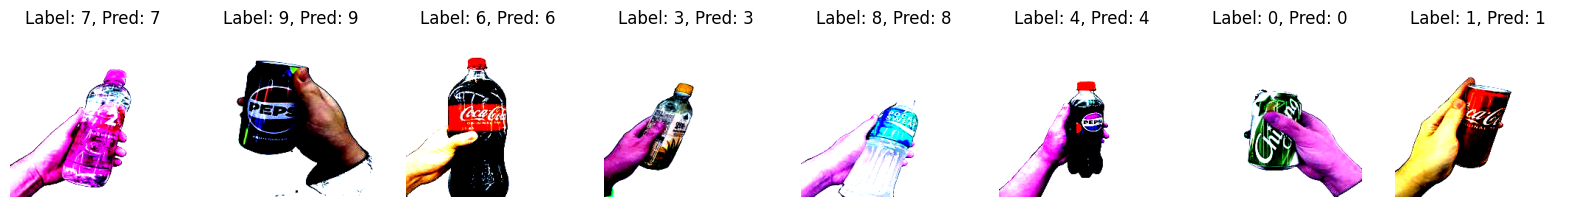

Validation Epoch 21: 100%|██████████| 2/2 [00:00<00:00, 41.37it/s]


Epoch 21, Train Loss: 0.20564197842031717, Val Loss: 0.07609576731920242


Validation Epoch 22: 100%|██████████| 2/2 [00:00<00:00, 34.21it/s]


Epoch 22, Train Loss: 0.11985206510871649, Val Loss: 0.018656053201993927


Validation Epoch 23: 100%|██████████| 2/2 [00:00<00:00, 30.90it/s]


Epoch 23, Train Loss: 0.029710881120990962, Val Loss: 0.01737053319811821


Validation Epoch 24: 100%|██████████| 2/2 [00:00<00:00, 33.23it/s]


Epoch 24, Train Loss: 0.05133563210256398, Val Loss: 0.019461186428088695


Validation Epoch 25: 100%|██████████| 2/2 [00:00<00:00, 32.95it/s]


Epoch 25, Train Loss: 0.02590562729164958, Val Loss: 0.2127948272973299


Validation Epoch 26: 100%|██████████| 2/2 [00:00<00:00, 33.58it/s]


Epoch 26, Train Loss: 0.04102466313634068, Val Loss: 0.05043518450111151


Validation Epoch 27: 100%|██████████| 2/2 [00:00<00:00, 33.51it/s]


Epoch 27, Train Loss: 0.046561866300180554, Val Loss: 0.12771178875118494


Validation Epoch 28: 100%|██████████| 2/2 [00:00<00:00, 32.98it/s]


Epoch 28, Train Loss: 0.10883993201423436, Val Loss: 0.027984800515696406


Validation Epoch 29: 100%|██████████| 2/2 [00:00<00:00, 34.14it/s]


Epoch 29, Train Loss: 0.0522151353652589, Val Loss: 0.031728113535791636


Validation Epoch 30: 100%|██████████| 2/2 [00:00<00:00, 33.58it/s]


Epoch 30, Train Loss: 0.040901768021285534, Val Loss: 0.02785095589933917


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


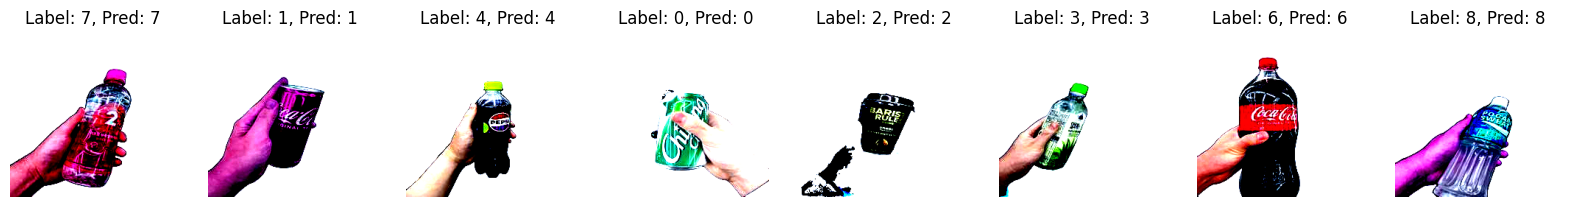

Validation Epoch 31: 100%|██████████| 2/2 [00:00<00:00, 34.64it/s]


Epoch 31, Train Loss: 0.034470360493287444, Val Loss: 0.03067442448809743


Validation Epoch 32: 100%|██████████| 2/2 [00:00<00:00, 34.07it/s]


Epoch 32, Train Loss: 0.0466932263225317, Val Loss: 0.03477896220283583


Validation Epoch 33: 100%|██████████| 2/2 [00:00<00:00, 33.53it/s]


Epoch 33, Train Loss: 0.1013707669917494, Val Loss: 0.022595491784159094


Validation Epoch 34: 100%|██████████| 2/2 [00:00<00:00, 33.33it/s]


Epoch 34, Train Loss: 0.03743930603377521, Val Loss: 0.01829717878717929


Validation Epoch 35: 100%|██████████| 2/2 [00:00<00:00, 33.60it/s]


Epoch 35, Train Loss: 0.0344765589106828, Val Loss: 0.05696677602827549


Validation Epoch 36: 100%|██████████| 2/2 [00:00<00:00, 33.45it/s]


Epoch 36, Train Loss: 0.05655192770063877, Val Loss: 0.049189497192855924


Validation Epoch 37: 100%|██████████| 2/2 [00:00<00:00, 33.18it/s]


Epoch 37, Train Loss: 0.023810009006410837, Val Loss: 0.032365318562369794


Validation Epoch 38: 100%|██████████| 2/2 [00:00<00:00, 33.41it/s]


Epoch 38, Train Loss: 0.0687798751750961, Val Loss: 0.22042104904539883


Validation Epoch 39: 100%|██████████| 2/2 [00:00<00:00, 33.67it/s]


Epoch 39, Train Loss: 0.04920906381448731, Val Loss: 0.02718852023826912


Validation Epoch 40: 100%|██████████| 2/2 [00:00<00:00, 33.82it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40, Train Loss: 0.03716407832689583, Val Loss: 0.025619817359256558


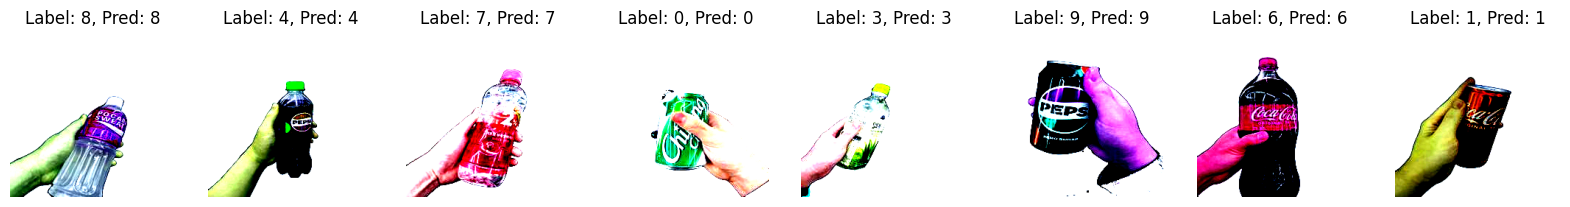

Validation Epoch 41: 100%|██████████| 2/2 [00:00<00:00, 34.37it/s]


Epoch 41, Train Loss: 0.04366564890369773, Val Loss: 0.03020572243258357


Validation Epoch 42: 100%|██████████| 2/2 [00:00<00:00, 32.76it/s]


Epoch 42, Train Loss: 0.04021550272591412, Val Loss: 0.04494343511760235


Validation Epoch 43: 100%|██████████| 2/2 [00:00<00:00, 33.25it/s]


Epoch 43, Train Loss: 0.04226025263778865, Val Loss: 0.039080820279195905


Validation Epoch 44: 100%|██████████| 2/2 [00:00<00:00, 32.44it/s]


Epoch 44, Train Loss: 0.04469515185337514, Val Loss: 0.25794817274436355


Validation Epoch 45: 100%|██████████| 2/2 [00:00<00:00, 33.05it/s]


Epoch 45, Train Loss: 0.056188216200098395, Val Loss: 0.027437357217422687


Validation Epoch 46: 100%|██████████| 2/2 [00:00<00:00, 33.07it/s]


Epoch 46, Train Loss: 0.04524961160495877, Val Loss: 0.0285137842874974


Validation Epoch 47: 100%|██████████| 2/2 [00:00<00:00, 33.28it/s]


Epoch 47, Train Loss: 0.026856310898438096, Val Loss: 0.019645790569484234


Validation Epoch 48: 100%|██████████| 2/2 [00:00<00:00, 31.61it/s]


Epoch 48, Train Loss: 0.05360285728238523, Val Loss: 0.017297881771810353


Validation Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 33.53it/s]


Epoch 49, Train Loss: 0.04199757496826351, Val Loss: 0.14092516817618161


Validation Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 33.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 50, Train Loss: 0.04112127097323537, Val Loss: 0.02040962252067402


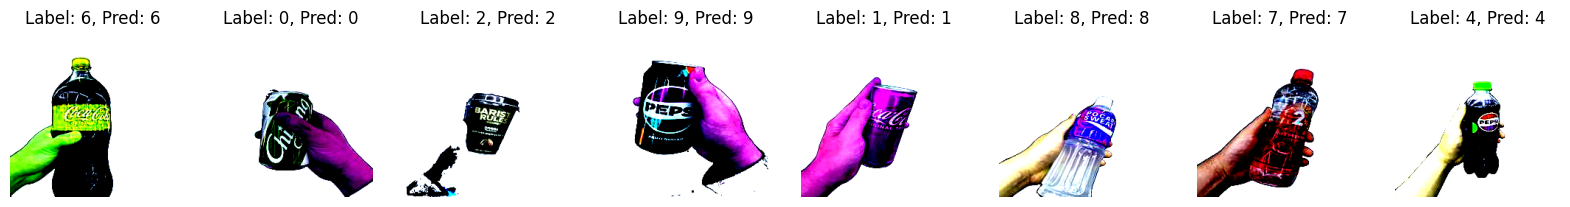

Validation Epoch 51: 100%|██████████| 2/2 [00:00<00:00, 34.23it/s]


Epoch 51, Train Loss: 0.031135150347836316, Val Loss: 0.1915703695267439


Validation Epoch 52: 100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 52, Train Loss: 0.20154985098633915, Val Loss: 0.022935134620638564


Validation Epoch 53: 100%|██████████| 2/2 [00:00<00:00, 32.86it/s]


Epoch 53, Train Loss: 0.057832813821733, Val Loss: 0.03206551494076848


Validation Epoch 54: 100%|██████████| 2/2 [00:00<00:00, 23.45it/s]


Epoch 54, Train Loss: 0.031018015812151134, Val Loss: 0.08604541048407555


Validation Epoch 55: 100%|██████████| 2/2 [00:00<00:00, 32.52it/s]


Epoch 55, Train Loss: 0.03643784567248076, Val Loss: 0.042928250040858984


Validation Epoch 56: 100%|██████████| 2/2 [00:00<00:00, 32.41it/s]


Epoch 56, Train Loss: 0.05716340825892985, Val Loss: 0.03378640068694949


Validation Epoch 57: 100%|██████████| 2/2 [00:00<00:00, 31.94it/s]


Epoch 57, Train Loss: 0.02430615935008973, Val Loss: 0.04679164523258805


Validation Epoch 58: 100%|██████████| 2/2 [00:00<00:00, 32.65it/s]


Epoch 58, Train Loss: 0.031880603288300335, Val Loss: 0.025952991854865104


Validation Epoch 59: 100%|██████████| 2/2 [00:00<00:00, 29.78it/s]


Epoch 59, Train Loss: 0.031620237161405385, Val Loss: 0.030010436312295496


Validation Epoch 60: 100%|██████████| 2/2 [00:00<00:00, 30.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60, Train Loss: 0.03386165353003889, Val Loss: 0.03572260937653482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


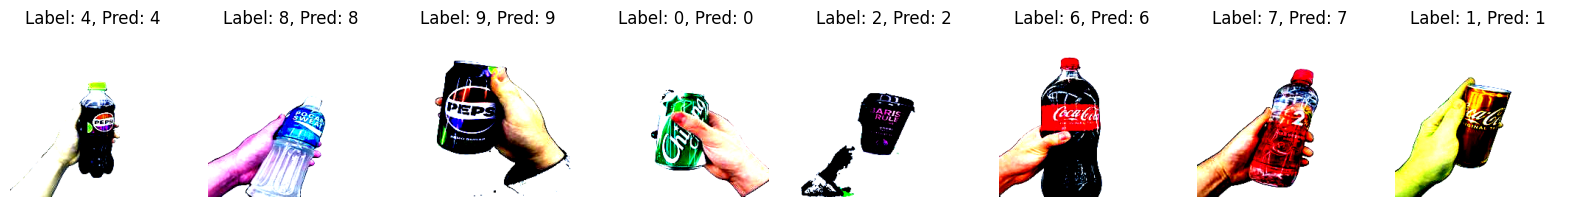

Validation Epoch 61: 100%|██████████| 2/2 [00:00<00:00, 33.80it/s]


Epoch 61, Train Loss: 0.03333076345734298, Val Loss: 0.04201441176701337


Validation Epoch 62: 100%|██████████| 2/2 [00:00<00:00, 28.98it/s]


Epoch 62, Train Loss: 0.08530644956044853, Val Loss: 0.11302977800369263


Validation Epoch 63: 100%|██████████| 2/2 [00:00<00:00, 30.95it/s]


Epoch 63, Train Loss: 0.08123832143610343, Val Loss: 0.027607394382357597


Validation Epoch 64: 100%|██████████| 2/2 [00:00<00:00, 30.01it/s]


Epoch 64, Train Loss: 0.04504991788417101, Val Loss: 0.03123021498322487


Validation Epoch 65: 100%|██████████| 2/2 [00:00<00:00, 26.29it/s]


Epoch 65, Train Loss: 0.05872736847959459, Val Loss: 0.03146012220531702


Validation Epoch 66: 100%|██████████| 2/2 [00:00<00:00, 30.16it/s]


Epoch 66, Train Loss: 0.0422796334605664, Val Loss: 0.05507028941065073


Validation Epoch 67: 100%|██████████| 2/2 [00:00<00:00, 33.33it/s]


Epoch 67, Train Loss: 0.018435212085023522, Val Loss: 0.12311037257313728


Validation Epoch 68: 100%|██████████| 2/2 [00:00<00:00, 29.87it/s]


Epoch 68, Train Loss: 0.03559878270607442, Val Loss: 0.04707762598991394


Validation Epoch 69: 100%|██████████| 2/2 [00:00<00:00, 30.27it/s]


Epoch 69, Train Loss: 0.03929727163631469, Val Loss: 0.038519456051290035


Validation Epoch 70: 100%|██████████| 2/2 [00:00<00:00, 32.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 70, Train Loss: 0.06426425615791231, Val Loss: 0.03662910865386948


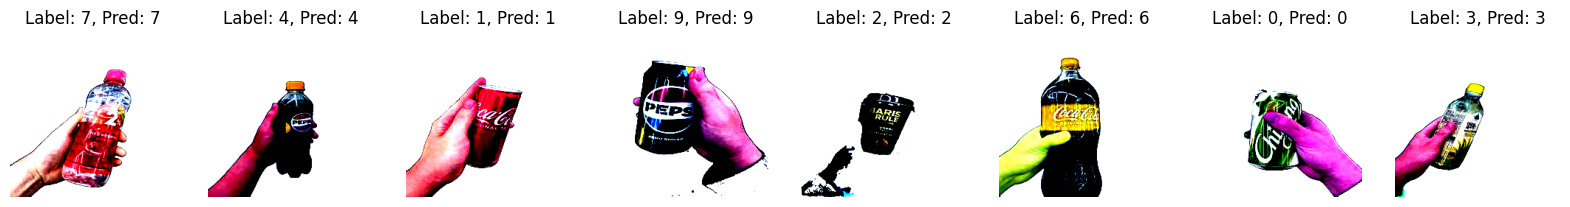

Validation Epoch 71: 100%|██████████| 2/2 [00:00<00:00, 33.57it/s]


Epoch 71, Train Loss: 0.06897313438821584, Val Loss: 0.05490847711917013


Validation Epoch 72: 100%|██████████| 2/2 [00:00<00:00, 32.19it/s]


Epoch 72, Train Loss: 0.03828478918876499, Val Loss: 0.030039450153708458


Validation Epoch 73: 100%|██████████| 2/2 [00:00<00:00, 31.65it/s]


Epoch 73, Train Loss: 0.04525190615095198, Val Loss: 0.032866562716662884


Validation Epoch 74: 100%|██████████| 2/2 [00:00<00:00, 31.87it/s]


Epoch 74, Train Loss: 0.05323657765984535, Val Loss: 0.026711420388892293


Validation Epoch 75: 100%|██████████| 2/2 [00:00<00:00, 32.61it/s]


Epoch 75, Train Loss: 0.038110190187580884, Val Loss: 0.022127377276774496


Validation Epoch 76: 100%|██████████| 2/2 [00:00<00:00, 37.39it/s]


Epoch 76, Train Loss: 0.03799862018786371, Val Loss: 0.02605999051593244


Validation Epoch 77: 100%|██████████| 2/2 [00:00<00:00, 32.55it/s]


Epoch 77, Train Loss: 0.03772516141179949, Val Loss: 0.06893001310527325


Validation Epoch 78: 100%|██████████| 2/2 [00:00<00:00, 31.06it/s]


Epoch 78, Train Loss: 0.028706412413157523, Val Loss: 0.017301897416473366


Validation Epoch 79: 100%|██████████| 2/2 [00:00<00:00, 31.93it/s]


Epoch 79, Train Loss: 0.02396213193424046, Val Loss: 0.018272110959514976


Validation Epoch 80: 100%|██████████| 2/2 [00:00<00:00, 31.92it/s]


Epoch 80, Train Loss: 0.036210466001648456, Val Loss: 0.02012347336858511


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


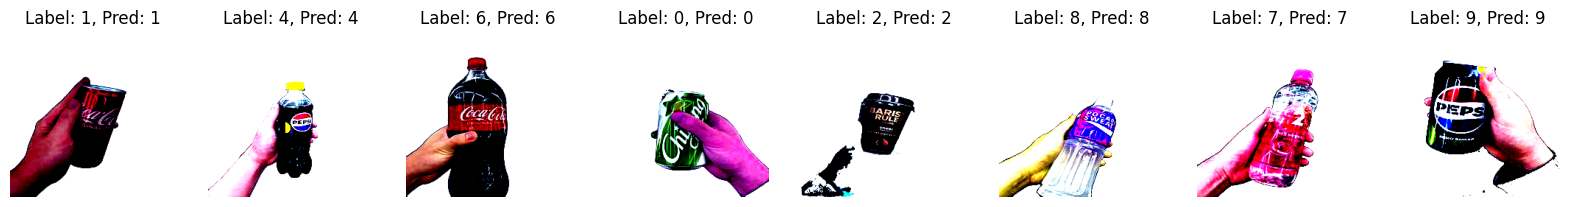

Validation Epoch 81: 100%|██████████| 2/2 [00:00<00:00, 32.46it/s]


Epoch 81, Train Loss: 0.0330748570850119, Val Loss: 0.021914038923569024


Validation Epoch 82: 100%|██████████| 2/2 [00:00<00:00, 31.04it/s]


Epoch 82, Train Loss: 0.05267579708015546, Val Loss: 0.031795868650078773


Validation Epoch 83: 100%|██████████| 2/2 [00:00<00:00, 28.70it/s]


Epoch 83, Train Loss: 0.05397874675691128, Val Loss: 0.028067455597920343


Validation Epoch 84: 100%|██████████| 2/2 [00:00<00:00, 32.52it/s]


Epoch 84, Train Loss: 0.0351775074377656, Val Loss: 0.040832877304637805


Validation Epoch 85: 100%|██████████| 2/2 [00:00<00:00, 31.85it/s]


Epoch 85, Train Loss: 0.027180682634934783, Val Loss: 0.12312125787138939


Validation Epoch 86: 100%|██████████| 2/2 [00:00<00:00, 32.18it/s]


Epoch 86, Train Loss: 0.04907201265450567, Val Loss: 0.05491974763572216


Validation Epoch 87: 100%|██████████| 2/2 [00:00<00:00, 32.33it/s]


Epoch 87, Train Loss: 0.05963326198980212, Val Loss: 0.048645001370459795


Validation Epoch 88: 100%|██████████| 2/2 [00:00<00:00, 31.79it/s]


Epoch 88, Train Loss: 0.04548826068639755, Val Loss: 0.041510678944177926


Validation Epoch 89: 100%|██████████| 2/2 [00:00<00:00, 32.50it/s]


Epoch 89, Train Loss: 0.02246106881648302, Val Loss: 0.0375654180534184


Validation Epoch 90: 100%|██████████| 2/2 [00:00<00:00, 32.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 90, Train Loss: 0.09418759413529187, Val Loss: 0.03149446239694953


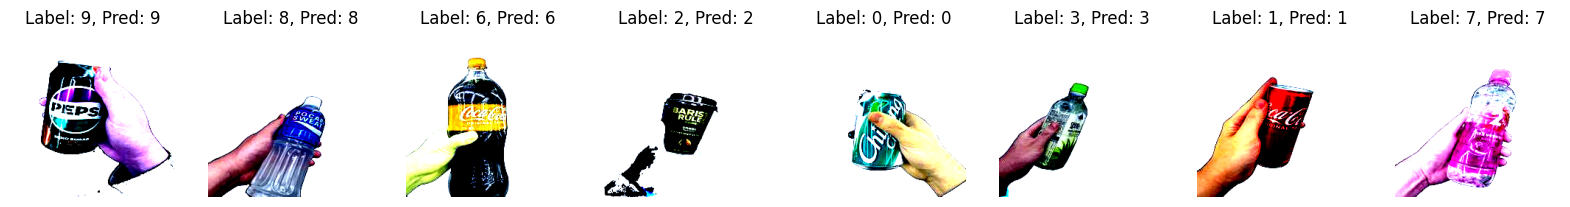

Validation Epoch 91: 100%|██████████| 2/2 [00:00<00:00, 32.94it/s]


Epoch 91, Train Loss: 0.047279738588258624, Val Loss: 0.040816618711687624


Validation Epoch 92: 100%|██████████| 2/2 [00:00<00:00, 30.95it/s]


Epoch 92, Train Loss: 0.06958350446075201, Val Loss: 0.041200614476110786


Validation Epoch 93: 100%|██████████| 2/2 [00:00<00:00, 27.76it/s]


Epoch 93, Train Loss: 0.023497983813285828, Val Loss: 0.048870499507756904


Validation Epoch 94: 100%|██████████| 2/2 [00:00<00:00, 32.60it/s]


Epoch 94, Train Loss: 0.02531641721725464, Val Loss: 0.05119989992817864


Validation Epoch 95: 100%|██████████| 2/2 [00:00<00:00, 35.74it/s]


Epoch 95, Train Loss: 0.03808391385246068, Val Loss: 0.031356136430986226


Validation Epoch 96: 100%|██████████| 2/2 [00:00<00:00, 37.36it/s]


Epoch 96, Train Loss: 0.10156795720104128, Val Loss: 0.017671775189228356


Validation Epoch 97: 100%|██████████| 2/2 [00:00<00:00, 39.78it/s]


Epoch 97, Train Loss: 0.043500852247234434, Val Loss: 0.026355751673690975


Validation Epoch 98: 100%|██████████| 2/2 [00:00<00:00, 30.24it/s]


Epoch 98, Train Loss: 0.03714334237156436, Val Loss: 0.03222043177811429


Validation Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 30.39it/s]


Epoch 99, Train Loss: 0.027285235817544162, Val Loss: 0.027713766263332218


Validation Epoch 100: 100%|██████████| 2/2 [00:00<00:00, 30.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, Train Loss: 0.04687489167554304, Val Loss: 0.062140949070453644


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


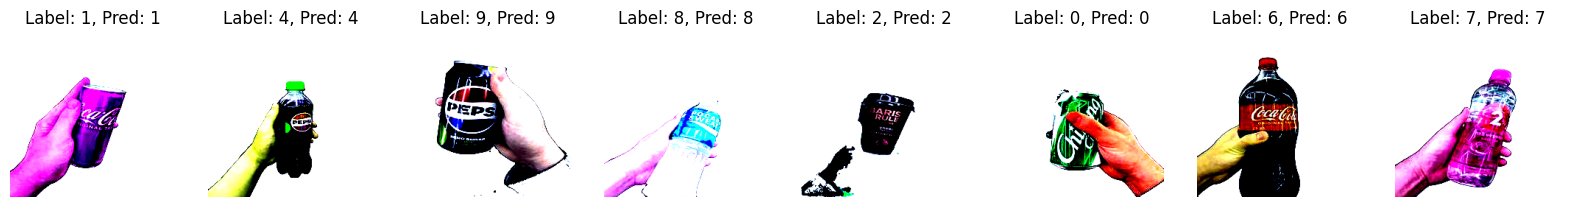

In [6]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# 초기 최소 검증 손실값 설정
min_val_loss = float('inf')

# 학습 및 검증 과정
train_losses = []
val_losses = []

for epoch in range(100): 
    model.train()
    train_loss, val_loss = 0.0, 0.0
    
    # 학습 부분
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # 검증 부분
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # 에폭별 손실 출력
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    # 스케줄러 업데이트
    scheduler.step(avg_val_loss)

    # 검증 손실이 개선되었는지 확인하고 모델 저장
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        torch.save(model.state_dict(), './snack_pt_0520_resnet18/best.pt')
        print(f"Model saved: Epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

    # 5 에폭마다 손실값 시각화
    # if (epoch + 1) % 5 == 0:
    #     plt.figure(figsize=(10, 5))
    #     plt.plot(range(1, epoch+2), train_losses, label='Train Loss')
    #     plt.plot(range(1, epoch+2), val_losses, label='Validation Loss')
    #     plt.xlabel('Epoch')
    #     plt.ylabel('Loss')
    #     plt.title('Train and Validation Loss')
    #     plt.legend()
    #     plt.grid(True)
    #     plt.savefig(f'./snack_pt_0520_resnet18/loss_plot_epoch_{epoch+1}.png')
    #     plt.show()
    
    # 10 에폭마다 검증 데이터의 이미지, 예측값, 실제 라벨 시각화
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            images, labels = next(iter(val_loader))
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            fig, axes = plt.subplots(1, len(images), figsize=(20, 4))
            for i, (img, lbl, out) in enumerate(zip(images, labels, outputs)):
                ax = axes[i]
                ax.imshow(img.permute(1, 2, 0).cpu().numpy())
                ax.set_title(f'Label: {lbl.item()}, Pred: {torch.argmax(out).item()}')
                ax.axis('off')
            plt.savefig(f'./snack_pt_0520_resnet18/sample_images_epoch_{epoch+1}.png')
            plt.show()


# 마지막 모델 상태 저장
torch.save(model.state_dict(), f'./snack_pt_0520_resnet18/last_{min_val_loss:.2f}.pt')
